# HW 5 - Real Time Machine Learning
Jacob Barker
801075553


In [1]:
import os
import tensorflow as tf
from d2l import tensorflow as d2l
import collections
import math
import numpy as np


2023-04-19 21:57:48.309945: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 21:57:48.941994: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/jacob/miniconda3/envs/tf/lib/
2023-04-19 21:57:48.942063: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/jacob/miniconda3/envs/tf/lib/
2023-04-19 21:57:48.942068: W tensorflow/compiler/tf2ten

# Problem 1 (40pts)

For the problem of Machine Translation using sequence-to-sequence model

In [2]:
data = d2l.MTFraEng(batch_size=3)
raw_text = data._download()
text = data._preprocess(raw_text)
src, tgt = data._tokenize(text)
data = d2l.MTFraEng(batch_size=3)
src, tgt, src_valid_len, label = next(iter(data.train_dataloader()))
src, tgt, _,  _ = data.build(['hi .'], ['salut .'])


2023-04-19 21:57:54.339272: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-04-19 21:57:54.339295: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: jacobs-PC
2023-04-19 21:57:54.339300: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: jacobs-PC
2023-04-19 21:57:54.339360: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.182.3
2023-04-19 21:57:54.339378: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.182.3
2023-04-19 21:57:54.339382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.182.3
2023-04-19 21:57:54.339587: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Networ

1- Can you adjust the hyperparameters to improve the translation results?

In [3]:
#setting up seq2seq from lectures
class Seq2SeqEncoder(d2l.Encoder):  #@save
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(num_hiddens, num_layers, dropout)

    def call(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(tf.transpose(X))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state


In [4]:
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(num_hiddens, num_layers, dropout)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def call(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(tf.transpose(X))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = tf.tile(tf.expand_dims(context, 0), (embs.shape[0], 1, 1))
        # Concat at the feature dimension
        embs_and_context = tf.concat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = tf.transpose(self.dense(outputs), (1, 0, 2))
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]


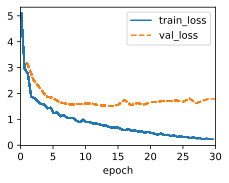

In [5]:
#trying the base Model seq2seq
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
with d2l.try_gpu():
    encoder = d2l.Seq2SeqEncoder(
        len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
    decoder = Seq2SeqDecoder(
        len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
    model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1)
trainer.fit(model, data)


In [6]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')


go . => ['<unk>', '.'], bleu,0.000
i lost . => ['je', 'suis', 'certain', '.'], bleu,0.000
he's calm . => ['il', 'court', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


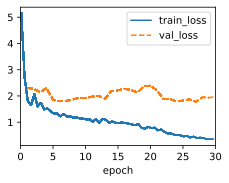

In [7]:
#modifying the hyper paramters of base model to improve translation
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 3, 0.2
with d2l.try_gpu():
    encoder = d2l.Seq2SeqEncoder(
        len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
    decoder = Seq2SeqDecoder(
        len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
    model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1)
trainer.fit(model, data)

In [8]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')


go . => ['<unk>', '!'], bleu,0.000
i lost . => ['je', 'gagné', '.'], bleu,0.000
he's calm . => ['il', 'est', 'perdu', '.'], bleu,0.658
i'm home . => ['je', 'suis', '<unk>', '.'], bleu,0.512


2. If the encoder and the decoder differ in the number of layers or the number of hidden units, how can we initialize the hidden state of the decoder? Please run an experiment for it with 3 layers for encoder and 2 layers for decoder. Plot your training results and compare it against the baseline examples from the lectures.

In [71]:
class Seq2Seq2(EncoderDecoder2):
    """The RNN encoder-decoder for sequence to sequence learning.
    Defined in :numref:`sec_seq2seq_decoder`"""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return tf.keras.optimizers.Adam(learning_rate=self.lr)

def bleu(pred_seq, label_seq, k):
    """Compute the BLEU.
    Defined in :numref:`sec_seq2seq_training`"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [72]:
class EncoderDecoder2(d2l.Classifier):
    """The base class for the encoder-decoder architecture.
    Defined in :numref:`sec_encoder-decoder`"""
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def call(self, enc_X, dec_X, *args):
        enc_all_outputs = self.encoder(enc_X, *args, training=True)
        dec_state = self.decoder.init_state(enc_all_outputs, *args)
        # Return decoder output only
        return self.decoder(dec_X, dec_state, training=True)[0]

    def predict_step(self, batch, device, num_steps,
                     save_attention_weights=False):
        """Defined in :numref:`sec_seq2seq_training`"""
        src, tgt, src_valid_len, _ = batch
        enc_all_outputs = self.encoder(src, src_valid_len, training=False)
        dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
        outputs, attention_weights = [d2l.expand_dims(tgt[:, 0], 1), ], []
        for _ in range(num_steps):
            Y, dec_state = self.decoder(outputs[-1], dec_state, training=False)
            outputs.append(d2l.argmax(Y, 2))
            # Save attention weights (to be covered later)
            if save_attention_weights:
                attention_weights.append(self.decoder.attention_weights)
        return d2l.concat(outputs[1:], 1), attention_weights

class GRU(d2l.RNN):
    """The multi-layer GRU model.
    Defined in :numref:`sec_deep_rnn`"""
    def __init__(self, num_hiddens, num_layers, dropout=0):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        gru_cells = [tf.keras.layers.GRUCell(num_hiddens, dropout=dropout)
                     for _ in range(num_layers)]
        self.conv = tf.keras.layers.Conv2D(num_layers, kernel_size=(1,1))
        self.rnn = tf.keras.layers.RNN(gru_cells, return_sequences=True,
                                       return_state=True, time_major=True)

    def forward(self, X, state=None):
        outputs, *state = self.rnn(X, state)
        return outputs, state

In [73]:
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = GRU(num_hiddens, num_layers, dropout)
        self.conv = tf.keras.layers.Convolution2D(num_layers, kernel_size=(1,1))
        self.dense = tf.keras.layers.Dense(vocab_size)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def call(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(tf.transpose(X))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = tf.tile(tf.expand_dims(context, 0), (embs.shape[0], 1, 1))
        # Concat at the feature dimension
        embs_and_context = tf.concat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = tf.transpose(self.dense(outputs), (1, 0, 2))
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

In [74]:
#running seq2seq model with encoder layers of 3 and deccoder layers of 2
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, dropout = 256, 256, 0.2
with d2l.try_gpu():
    encoder = d2l.Seq2SeqEncoder(
        len(data.src_vocab), embed_size, num_hiddens, 3, dropout)
    decoder = Seq2SeqDecoder(
        len(data.tgt_vocab), embed_size, num_hiddens, 2, dropout)
    model = Seq2Seq2(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1)
trainer.fit(model, data)

ValueError: Exception encountered when calling layer 'gru_35' (type GRU).

An `initial_state` was passed that is not compatible with `cell.state_size`. Received `state_spec`=ListWrapper([InputSpec(shape=(128, 256), ndim=2), InputSpec(shape=(128, 256), ndim=2), InputSpec(shape=(128, 256), ndim=2)]); however `cell.state_size` is [256, 256]

Call arguments received by layer 'gru_35' (type GRU):
  • X=tf.Tensor(shape=(9, 128, 512), dtype=float32)
  • args=(['tf.Tensor(shape=(128, 256), dtype=float32)', 'tf.Tensor(shape=(128, 256), dtype=float32)', 'tf.Tensor(shape=(128, 256), dtype=float32)'],)
  • kwargs={'training': 'True'}

3. Rerun the baseline experiment by replacing GRU with LSTM. Plot your results and compare GRU against LSTM.

In [36]:
#Modified GRU class for LSTM
class LSTM(d2l.RNN):
    """The multi-layer LSTM model.
    Defined in :numref:`sec_deep_rnn`"""
    def __init__(self, num_hiddens, num_layers, dropout=0):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        lstm_cells = [tf.keras.layers.LSTMCell(num_hiddens, dropout=dropout)
                     for _ in range(num_layers)]
        self.rnn = tf.keras.layers.RNN(lstm_cells, return_sequences=True,
                                       return_state=True, time_major=True)

    def forward(self, X, state=None):
        outputs, *state = self.rnn(X, state)
        return outputs, state

In [37]:
#Modification of encoder and decoder to use LSTM
class Seq2SeqEncoder(d2l.Encoder):  #@save
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = LSTM(num_hiddens, num_layers, dropout)

    def call(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(tf.transpose(X))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state
    
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = LSTM(num_hiddens, num_layers, dropout)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def call(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(tf.transpose(X))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = tf.tile(tf.expand_dims(context, 0), (embs.shape[0], 1, 1))
        # Concat at the feature dimension
        embs_and_context = tf.concat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = tf.transpose(self.dense(outputs), (1, 0, 2))
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

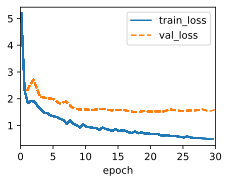

In [38]:
#seq2seq using LSTM
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
with d2l.try_gpu():
    encoder = Seq2SeqEncoder(
        len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
    decoder = Seq2SeqDecoder(
        len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
    model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1)
trainer.fit(model, data)

In [39]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')


go . => ['soyez', '<unk>', '!'], bleu,0.000
i lost . => ['je', 'suis', '<unk>', '.'], bleu,0.000
he's calm . => ['il', '<unk>', '.'], bleu,0.000
i'm home . => ['je', 'suis', '<unk>', '.'], bleu,0.512


# Problem 2 (60pts)

For the problem of Machine Translation with Bahdanau attention based sequence-to-sequence modeling

1. Explore the impacts of number of hidden layers starting tom 1 hidden layer up to 4 hidden layers. Plot the results (training loss and validation), also run few examples to do the qualitative comparison between these two. Can you draw the attention weight matrixes and compare them.

In [25]:
#setting up seq2seq with bahdanau attention
class Seq2SeqAttentionDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.attention = d2l.AdditiveAttention(num_hiddens, num_hiddens,
                                               num_hiddens, dropout)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells(
            [tf.keras.layers.GRUCell(num_hiddens, dropout=dropout)
             for _ in range(num_layers)]), return_sequences=True,
                                       return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        # Shape of outputs: (batch_size, num_steps, num_hiddens).
        # Length of list hidden_state is num_layers, where the shape of its
        # element is (batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        return (tf.transpose(outputs, (1, 0, 2)), hidden_state,
                enc_valid_lens)

    def call(self, X, state, **kwargs):
        # Shape of output enc_outputs: # (batch_size, num_steps, num_hiddens)
        # Length of list hidden_state is num_layers, where the shape of its
        # element is (batch_size, num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output X: (num_steps, batch_size, embed_size)
        X = self.embedding(X)  # Input X has shape: (batch_size, num_steps)
        X = tf.transpose(X, perm=(1, 0, 2))
        outputs, self._attention_weights = [], []
        for x in X:
            # Shape of query: (batch_size, 1, num_hiddens)
            query = tf.expand_dims(hidden_state[-1], axis=1)
            # Shape of context: (batch_size, 1, num_hiddens)
            context = self.attention(query, enc_outputs, enc_outputs,
                                     enc_valid_lens, **kwargs)
            # Concatenate on the feature dimension
            x = tf.concat((context, tf.expand_dims(x, axis=1)), axis=-1)
            out = self.rnn(x, hidden_state, **kwargs)
            hidden_state = out[1:]
            outputs.append(out[0])
            self._attention_weights.append(self.attention.attention_weights)
        # After fully connected layer transformation, shape of outputs:
        # (batch_size, num_steps, vocab_size)
        outputs = self.dense(tf.concat(outputs, axis=1))
        return outputs, [enc_outputs, hidden_state, enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights
    
class Seq2SeqEncoder(d2l.Encoder):  #@save
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(num_hiddens, num_layers, dropout)

    def call(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(tf.transpose(X))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state


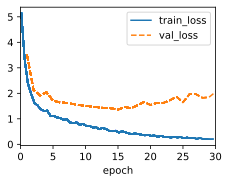

In [26]:
#1 Hidden Layer
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 1, 0.2
encoder = d2l.Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=0)
trainer.fit(model, data)


go . => ['va', ',', 'maintenant', '.'], bleu,0.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'essaye', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


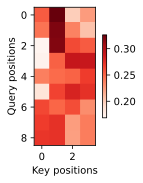

In [27]:
#test trained model
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')
    
#get attention weight matrix
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
attention_weights = tf.concat(
    [step[0][0][0] for step in dec_attention_weights], 0)
attention_weights = tf.reshape(attention_weights, (1, 1, -1, data.num_steps))

# Plus one to include the end-of-sequence token
d2l.show_heatmaps(attention_weights[:, :, :, :len(engs[-1].split()) + 1],
                  xlabel='Key positions', ylabel='Query positions')


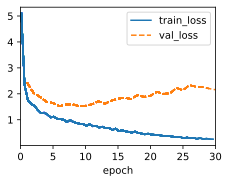

In [28]:
#2 Hidden Layers
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = d2l.Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=0)
trainer.fit(model, data)

go . => ['<unk>', '!'], bleu,0.000
i lost . => ['je', 'l’ai', 'vu', '.'], bleu,0.000
he's calm . => ['nous', 'fûmes', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'malade', '.'], bleu,0.512


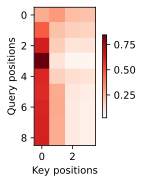

In [29]:
#test trained model
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')
    
#get attention weight matrix
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
attention_weights = tf.concat(
    [step[0][0][0] for step in dec_attention_weights], 0)
attention_weights = tf.reshape(attention_weights, (1, 1, -1, data.num_steps))

# Plus one to include the end-of-sequence token
d2l.show_heatmaps(attention_weights[:, :, :, :len(engs[-1].split()) + 1],
                  xlabel='Key positions', ylabel='Query positions')

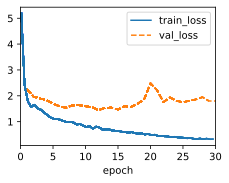

In [30]:
#3 Hidden Layers
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 3, 0.2
encoder = d2l.Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=0)
trainer.fit(model, data)

go . => ['<unk>', '!'], bleu,0.000
i lost . => ["j'ai", 'compris', '.'], bleu,0.000
he's calm . => ['il', '<unk>', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


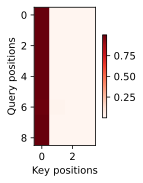

In [31]:
#test trained model
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')
    
#get attention weight matrix
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
attention_weights = tf.concat(
    [step[0][0][0] for step in dec_attention_weights], 0)
attention_weights = tf.reshape(attention_weights, (1, 1, -1, data.num_steps))

# Plus one to include the end-of-sequence token
d2l.show_heatmaps(attention_weights[:, :, :, :len(engs[-1].split()) + 1],
                  xlabel='Key positions', ylabel='Query positions')

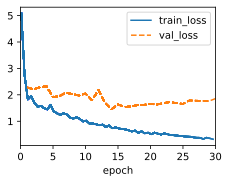

In [32]:
#4 Hidden Layers
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 4, 0.2
encoder = d2l.Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=0)
trainer.fit(model, data)

go . => ['<unk>', '.'], bleu,0.000
i lost . => ['tom', 'a', 'gagné', '.'], bleu,0.000
he's calm . => ['elle', 'est', '<unk>', '.'], bleu,0.000
i'm home . => ['je', 'suis', '<unk>', '.'], bleu,0.512


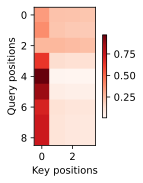

In [33]:
#test trained model
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')
    
#get attention weight matrix
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
attention_weights = tf.concat(
    [step[0][0][0] for step in dec_attention_weights], 0)
attention_weights = tf.reshape(attention_weights, (1, 1, -1, data.num_steps))

# Plus one to include the end-of-sequence token
d2l.show_heatmaps(attention_weights[:, :, :, :len(engs[-1].split()) + 1],
                  xlabel='Key positions', ylabel='Query positions')

2. Replace GRU with LSTM in the experiment. Perform training again. Plot the results (training loss and validation), also run few examples to do the qualitative comparison between these two. Can you draw the attention weight matrixes and compare them.

In [75]:
class AdditiveAttention(tf.keras.layers.Layer):
    """Additive attention.
    Defined in :numref:`subsec_batch_dot`"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super().__init__(**kwargs)
        self.W_k = tf.keras.layers.Dense(num_hiddens, use_bias=False)
        self.W_q = tf.keras.layers.Dense(num_hiddens, use_bias=False)
        self.w_v = tf.keras.layers.Dense(1, use_bias=False)
        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, queries, keys, values, valid_lens, **kwargs):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of queries: (batch_size, no. of
        # queries, 1, num_hiddens) and shape of keys: (batch_size, 1, no. of
        # key-value pairs, num_hiddens). Sum them up with broadcasting
        features = tf.expand_dims(queries, axis=2) + tf.expand_dims(
            keys, axis=1)
        features = tf.nn.tanh(features)
        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape. Shape of scores: (batch_size,
        # no. of queries, no. of key-value pairs)
        scores = tf.squeeze(self.w_v(features), axis=-1)
        self.attention_weights = d2l.masked_softmax(scores, valid_lens)
        # Shape of values: (batch_size, no. of key-value pairs, value
        # dimension)
        return tf.matmul(self.dropout(
            self.attention_weights, **kwargs), values)

class Seq2SeqAttentionDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.attention = AdditiveAttention(num_hiddens, num_hiddens,
                                               num_hiddens, dropout)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells(
            [tf.keras.layers.LSTMCell(num_hiddens, dropout=dropout)
             for _ in range(num_layers)]), return_sequences=True,
                                       return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        # Shape of outputs: (batch_size, num_steps, num_hiddens).
        # Length of list hidden_state is num_layers, where the shape of its
        # element is (batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        return (tf.transpose(outputs, (1, 0, 2)), hidden_state,
                enc_valid_lens)

    def call(self, X, state, **kwargs):
        # Shape of output enc_outputs: # (batch_size, num_steps, num_hiddens)
        # Length of list hidden_state is num_layers, where the shape of its
        # element is (batch_size, num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output X: (num_steps, batch_size, embed_size)
        X = self.embedding(X)  # Input X has shape: (batch_size, num_steps)
        X = tf.transpose(X, perm=(1, 0, 2))
        outputs, self._attention_weights = [], []
        for x in X:
            # Shape of query: (batch_size, 1, num_hiddens)
            query = tf.expand_dims(hidden_state[-1], axis=1)
            # Shape of context: (batch_size, 1, num_hiddens)
            context = self.attention(query, enc_outputs, enc_outputs,
                                     enc_valid_lens, **kwargs)
            #context = (128,1,256)
            # Concatenate on the feature dimension
            x = tf.concat((context, tf.expand_dims(x, axis=1)), axis=-1)
            out = self.rnn(x, hidden_state, **kwargs)
            hidden_state = out[1:]
            outputs.append(out[0])
            self._attention_weights.append(self.attention.attention_weights)
        # After fully connected layer transformation, shape of outputs:
        # (batch_size, num_steps, vocab_size)
        outputs = self.dense(tf.concat(outputs, axis=1))
        return outputs, [enc_outputs, hidden_state, enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights
    
class Seq2SeqEncoder(d2l.Encoder):  #@save
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = LSTM(num_hiddens, num_layers, dropout)

    def call(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(tf.transpose(X))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state


In [76]:
#re
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=0)
trainer.fit(model, data)


InvalidArgumentError: Exception encountered when calling layer 'additive_attention_5' (type AdditiveAttention).

{{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [2,1,1,128,256] vs. [128,1,9,256] [Op:AddV2]

Call arguments received by layer 'additive_attention_5' (type AdditiveAttention):
  • queries=tf.Tensor(shape=(2, 1, 128, 256), dtype=float32)
  • keys=tf.Tensor(shape=(128, 9, 256), dtype=float32)
  • values=tf.Tensor(shape=(128, 9, 256), dtype=float32)
  • valid_lens=tf.Tensor(shape=(128,), dtype=int32)
  • kwargs={'training': 'True'}